In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.set_printoptions(precision=4)

In [3]:
BIG_WIDTH = 3072

# typical Other settings: 
settings = [17, 0.5, 62, 5, 64, 200]

base = settings[0]
base_err = settings[1]
viewangle_x = settings[2] # in degrees
viewangle_x_err = settings[3] # in degrees
num_shades = int(settings[4])
min_height = settings[5]

resolution_x = BIG_WIDTH;
viewangle = np.pi * viewangle_x / 180.0

In [4]:
# g === area (big image) -- from RIGHT img (#2)
# f === fragment -- from LEFT img (#1)
date = "20160909-141139-078"

f = Image.open("img/" + date + "-1_aff_applied.png").convert('L')
g = Image.open("img/" + date + "-2_aff_applied.png").convert('L')

f = f.convert("P", palette=Image.ADAPTIVE, colors=num_shades)
g = g.convert("P", palette=Image.ADAPTIVE, colors=num_shades)

# Get fragment from left image
wf = 150
hf = 150

xf = np.random.randint(f.width / 4.0, 3 * f.width / 4.0)
yf = np.random.randint(f.height / 4.0, 3 * f.height / 4.0)

crop_box = (xf, yf, xf + wf, yf + hf)
f = f.crop(crop_box)


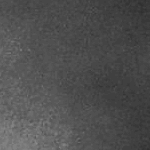

In [5]:
# Create matrix of fragment
f_mat = np.asarray(f.getdata(), dtype=np.int).reshape(f.size[1], f.size[0])
Image.fromarray((f_mat * 256 / num_shades).astype('uint8'), 'L')

(150, 150)
981 1208


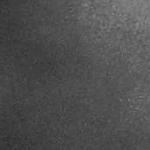

In [6]:
# Flip matrix
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

print f.size
print yf, xf
Image.fromarray((f_mat * 256 / num_shades).astype('uint8'), 'L')

In [7]:
# g === area (big image) -- from RIGHT img (#2)
# f === fragment -- from LEFT img (#1)


# mpd is Maximum Pixel Distance <--> Minimum cloud height(altitude)
mpd = base * resolution_x / (2 * np.tan(viewangle / 2.0) * min_height)
fac_x = 1; # reserve-coefficient
fac_y = 1.5; #reserve-coefficient

area_x = int(xf - fac_x * wf)
area_y = int(yf - fac_y * hf)
area_width = int(mpd + 2 * fac_x * wf)
area_height = int(2 * fac_y * hf)
print area_x, area_y
print area_width, area_height

# area to search on right image
g = g.crop( (area_x, area_y, 
                        area_x + area_width, area_y + area_height) ) 

wg = area_width
hg = area_height
xg = area_x
yg = area_y

1058 756
517 450


In [8]:
print g.size
g_mat = np.asarray(g.getdata(), dtype=np.int).reshape(g.size[1], g.size[0])

(517, 450)


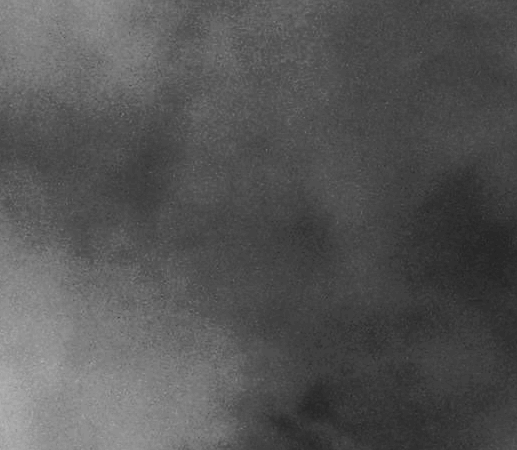

In [9]:
Image.fromarray((g_mat * 256 / num_shades).astype('uint8'), 'L')

In [10]:
# Seacrh algo here

In [11]:
# Create indicators of f
# of size == g.size
chi = np.zeros((num_shades, g.size[1], g.size[0]), dtype=bool)

In [12]:
# fill the indicators
for h in xrange(f.size[1]):
    for w in xrange(f.size[0]):
        color = f_mat[h, w]
        chi[color, h, w] = True

In [13]:
# chi_elems[i] === number of pixels that have color "i"
chi_elems = np.array( f.histogram() )

In [14]:
fft_chi = np.fft.fft2(chi)

In [15]:
fft_g = np.fft.fft2(g_mat)

In [16]:
# Scalar product (g_frag, chi[i])
sp_g_frag_chi = np.zeros((num_shades, g.size[1] - hf, g.size[0] - wf))

for i in xrange(num_shades):
    if chi_elems[i] > 0:
        sp_g_frag_chi[i] = np.fft.ifft2(fft_g * fft_chi[i])[hf:, wf:]

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ComplexWarning: Casting complex values to real discards the imaginary part


In [17]:
# || Projection of g_frag on f ||^2
norm_pr_gfrag_sqr = np.zeros((g.size[1] - hf, g.size[0] - wf))
for i in xrange(num_shades):
    if chi_elems[i] > 0:
        norm_pr_gfrag_sqr += sp_g_frag_chi[i] ** 2 / float(chi_elems[i])
        

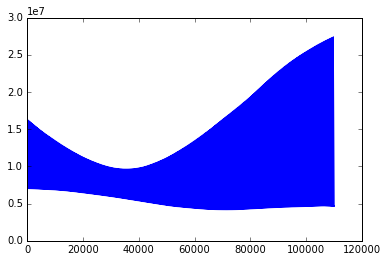

In [18]:
plt.plot(norm_pr_gfrag_sqr.ravel())

In [19]:
# chi_X -- const field of vision
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 0 0 0 0 0 ... 0
# . . .
# 0 0 0 0 0 ... 0
chi_X = np.zeros((g.size[1], g.size[0]), dtype=bool)
chi_X[:hf, :wf] = np.ones((hf, wf))

print g_mat.min()
print (g_mat**2).min()

# || g ||^2
fft_gsqr = np.fft.fft2(g_mat ** 2)
fft_chi_X = np.fft.fft2(chi_X)
norm_gfrag_sqr = np.fft.ifft2(fft_gsqr * fft_chi_X)[hf:, wf:].astype('float')

# norm_gfrag_sqr = abs(norm_gfrag_sqr)

8
64


/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [20]:
norm_E_gfrag_sqr = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float') \
                        ** 2 / (hf * wf)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


23719.4859473


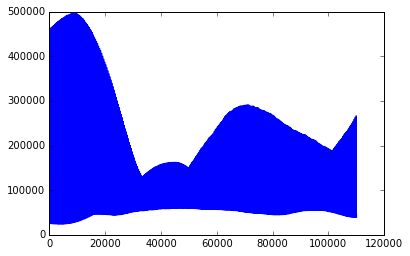

In [21]:
numerator = norm_gfrag_sqr - norm_pr_gfrag_sqr
plt.plot(numerator.ravel())
print numerator.min()

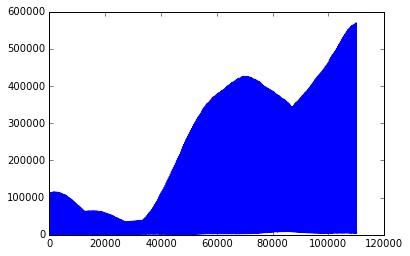

In [22]:
denominator = norm_pr_gfrag_sqr - norm_E_gfrag_sqr
plt.plot(denominator.ravel())

In [23]:
tau = numerator / denominator


85312
Left: 981 1208
Right: 989 1227


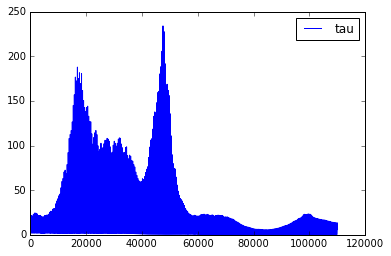

In [24]:
plt.plot(tau.ravel(), label='tau')
plt.legend()
idx_min = tau.argmin()
print idx_min

print 'Left:', yf, xf
y_found = idx_min // tau.shape[1] + 1
x_found = idx_min % tau.shape[1] + 1
print 'Right:', y_found + yg, x_found + xg

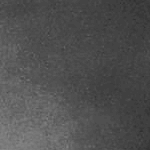

In [25]:
found_gfrag = g_mat[y_found : y_found + hf, x_found : x_found + wf]
Image.fromarray((found_gfrag * 256 / num_shades).astype('uint8'), 'L')

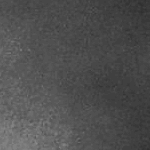

In [26]:
# Flip matrix
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

Image.fromarray((f_mat * 256 / num_shades).astype('uint8'), 'L')

In [27]:
# result x, y -- координаты кусочка, найденного в области поиска g
res_y, res_x = y_found + yg, x_found + xg

In [28]:
# Calculate altitude
x_pixel_distance = abs(res_x - xf)
viewangle = np.pi * viewangle_x / 180.0;
altitude = base * resolution_x / (2 * np.tan(viewangle / 2.0) * x_pixel_distance)
resolution_x_err = 2; #pixels

err_distance = base_err * resolution_x / ( 2 * np.tan(viewangle / 2.0) * x_pixel_distance )

err_viewangle = (viewangle_x_err * np.pi / 180.0) * ( base * resolution_x / \
                                                   (4.0 * x_pixel_distance * (np.sin(viewangle / 2.0)) ** 2) )

err_resolution = resolution_x_err * base * resolution_x / \
                    ( 2 * np.tan(viewangle / 2.0) * (x_pixel_distance) ** 2 ) 

total_error = np.sqrt( err_distance ** 2 + err_viewangle ** 2 + err_resolution ** 2 )
ratio_error = total_error * 100.0 / altitude


print "Search done"
print "Pixel distance:", x_pixel_distance
print "Altitude: %f +- %f meters (error is %f percent)" % (altitude, total_error, ratio_error)

Search done
Pixel distance: 19
Altitude: 2287.245571 +- 337.039562 meters (error is 14.735609 percent)


In [29]:
with open('results/' + date + '.txt', mode='a') as f:
    s = str(x_pixel_distance) + ' ' + str(altitude) + ' ' + \
        str(total_error) + '\n'
    f.write(s)
    